In [47]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [48]:
def str_to_datetime( s ):
    split = s.split( '-' )
    year, month, day = int( split[0] ), int( split[1] ), int( split[2] )
    return datetime.datetime( year = year, month = month, day = day )

In [62]:
df = pd.read_csv( 'xauusd_d.csv' )
df['Date'] = df['Date'].apply( str_to_datetime )
df.index = df.pop( 'Date' )
xau_quote = df

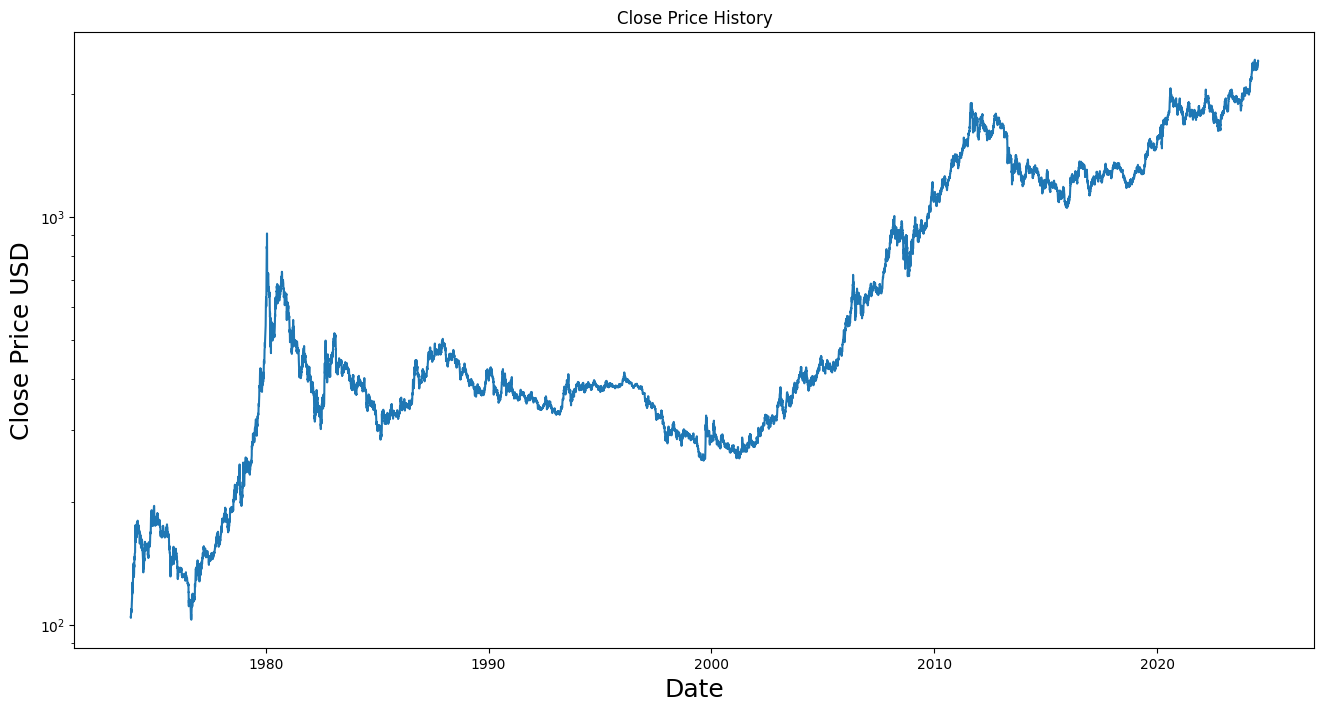

In [63]:
plt.figure( figsize = ( 16, 8 ) )
plt.title( 'Close Price History' )
plt.plot( df['Close'] )
plt.xlabel( 'Date', fontsize = 18 )
plt.ylabel( 'Close Price USD', fontsize = 18 )
plt.yscale( 'log' )
plt.show()

In [64]:
data = df.filter( ['Close'] )
dataset = data.values
training_data_len = math.ceil( len( dataset ) * .8 )

training_data_len

10329

In [65]:
scaler = MinMaxScaler( feature_range = ( 0, 1 ) )
scaled_data = scaler.fit_transform( dataset )

scaled_data

array([[6.45561122e-04],
       [4.73411489e-04],
       [1.03289779e-03],
       ...,
       [9.76327274e-01],
       [9.95259429e-01],
       [9.94146912e-01]])

In [66]:
train_data = scaled_data[ 0:training_data_len,: ]
x_train = []
y_train = []

for i in range( 60,len( train_data ) ):
    x_train.append( train_data[ i-60:i, 0 ] )
    y_train.append( train_data[ i, 0 ] )

    if i <= 61:
        print( x_train )
        print( y_train )
        print()

[array([0.00064556, 0.00047341, 0.0010329 , 0.00180757, 0.00275439,
       0.00249617, 0.00232402, 0.00180757, 0.00241009, 0.00301262,
       0.00395944, 0.00408855, 0.00503538, 0.00602524, 0.008048  ,
       0.00688599, 0.00817711, 0.01032898, 0.00925304, 0.00753155,
       0.00839229, 0.0095543 , 0.0098986 , 0.01019987, 0.01110365,
       0.01183529, 0.01605295, 0.01502006, 0.01377197, 0.0165694 ,
       0.01652636, 0.01592384, 0.01506309, 0.01420234, 0.01291122,
       0.01205047, 0.0133416 , 0.01613903, 0.01527828, 0.01570865,
       0.01743015, 0.0182909 , 0.01893646, 0.01786052, 0.01872127,
       0.01992632, 0.02022758, 0.02044277, 0.02332628, 0.02603763,
       0.02883506, 0.03120212, 0.03077175, 0.02582244, 0.02797432,
       0.02732875, 0.02431614, 0.02474651, 0.02732875, 0.02689838])]
[0.02711356711253423]

[array([0.00064556, 0.00047341, 0.0010329 , 0.00180757, 0.00275439,
       0.00249617, 0.00232402, 0.00180757, 0.00241009, 0.00301262,
       0.00395944, 0.00408855, 0.00

In [67]:
x_train, y_train = np.array( x_train ), np.array( y_train )

In [68]:
x_train = np.reshape( x_train, ( x_train.shape[0], x_train.shape[1], 1 ) )
x_train.shape

(10269, 60, 1)

In [80]:
model = Sequential()
model.add( LSTM( 50, return_sequences = True, input_shape = ( x_train.shape[1], 1 ) ) )
model.add( LSTM( 50, return_sequences = False ) )
model.add( Dense( 25 ) )
model.add( Dense( 1 ) )

In [81]:
model.compile( optimizer = 'adam', loss = 'mean_squared_error' )

In [82]:
model.fit( x_train, y_train, batch_size = 1, epochs = 1 )

10269/10269 [==============================] - 294s 28ms/step - loss: 2.8416e-04


In [83]:
test_data = scaled_data[ training_data_len - 60:, : ]
x_test = []
y_test = dataset[ training_data_len:, : ]

for i in range( 60, len( test_data ) ):
    x_test.append( test_data[ i-60:i, 0 ] )

In [84]:
x_test = np.array( x_test )
x_test = np.reshape( x_test,( x_test.shape[0], x_test.shape[1], 1 ) )
predictions = model.predict( x_test )
predictions = scaler.inverse_transform( predictions )

81/81 [==============================] - 2s 15ms/step


In [85]:
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

30.781026950780046

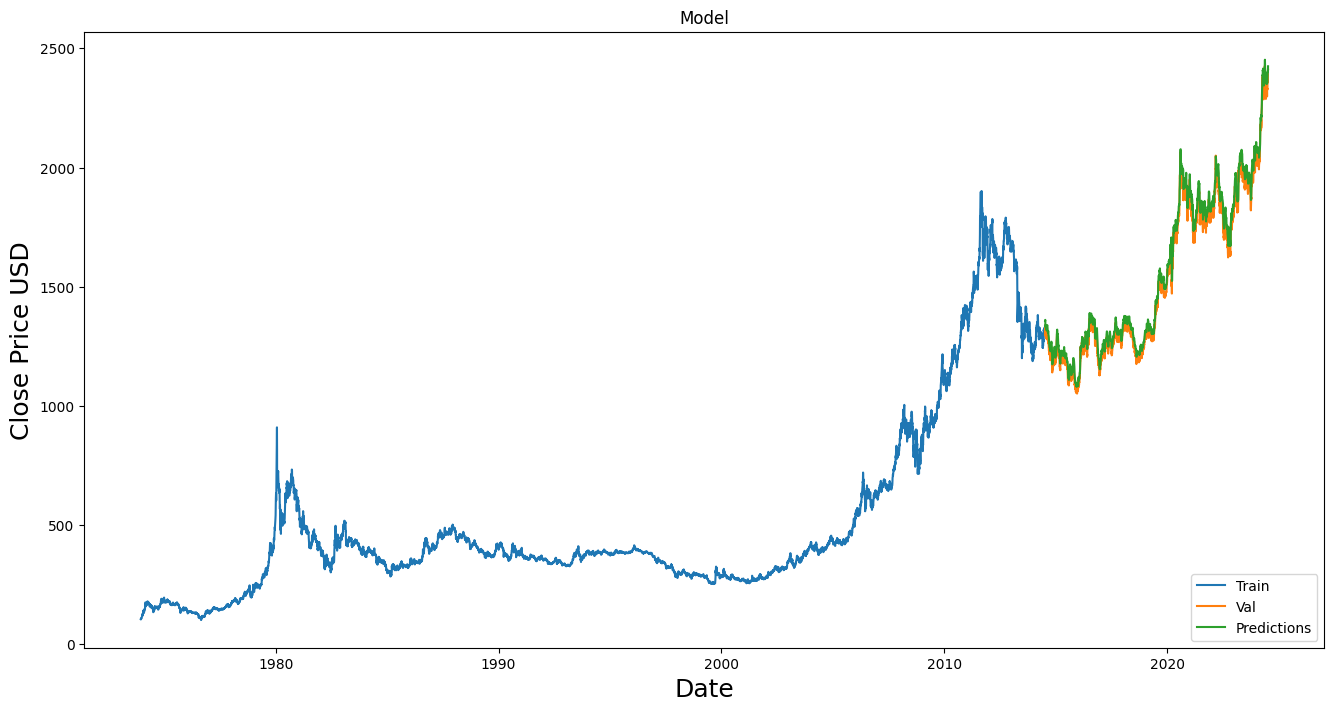

In [86]:
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure( figsize = ( 16,8 ) )
plt.title( 'Model' )
plt.xlabel( 'Date', fontsize = 18 )
plt.ylabel( 'Close Price USD', fontsize = 18 )
plt.plot( train['Close'] )
plt.plot( valid[ ['Close','Predictions'] ] )
plt.legend( ['Train','Val','Predictions'], loc = 'lower right' )
plt.show()

In [88]:
# Show the valid and predicted prices
print( valid )

               Close  Predictions
Date                             
2014-07-11  1337.480  1356.085449
2014-07-14  1306.920  1360.863281
2014-07-15  1293.970  1351.108521
2014-07-16  1299.030  1337.548218
2014-07-17  1319.100  1330.735596
...              ...          ...
2024-07-08  2359.045  2405.427734
2024-07-09  2364.025  2403.676270
2024-07-10  2371.355  2402.263428
2024-07-11  2415.345  2404.309814
2024-07-12  2412.760  2424.821777

[2582 rows x 2 columns]


In [89]:
new_df = xau_quote.filter( ['Close'] )
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform( last_60_days )
X_test = []
X_test.append( last_60_days_scaled )
X_test = np.array( X_test )
X_test = np.reshape( X_test, ( X_test.shape[0], X_test.shape[1], 1 ) )
pred_price = model.predict( X_test )
pred_price = scaler.inverse_transform( pred_price )
print( pred_price )

1/1 [==============================] - 0s 28ms/step
[[2437.6675]]


In [91]:
df_extended = df
close_prices_extended = df_extended[ 'Close' ].values.reshape( -1, 1 )
scaled_extended_data = scaler.transform( close_prices_extended )

x_extended_test = []

for i in range( len( df_extended ) - 60, len( df_extended ) ):
    x_extended_test.append( scaled_extended_data[ i-60:i, 0 ] )

x_extended_test = np.array( x_extended_test )
x_extended_test = np.reshape( x_extended_test, ( x_extended_test.shape[0], x_extended_test.shape[1], 1 ) )
extended_predictions = model.predict( x_extended_test )
extended_predictions = scaler.inverse_transform( extended_predictions )

# Calculate the difference between the last value of historical data and the first value of predicted data
prediction_difference = close_prices_extended[-1] - extended_predictions[0]

# Add the difference to the entire predicted dataset
extended_predictions_adjusted = extended_predictions + prediction_difference


2/2 [==============================] - 0s 25ms/step


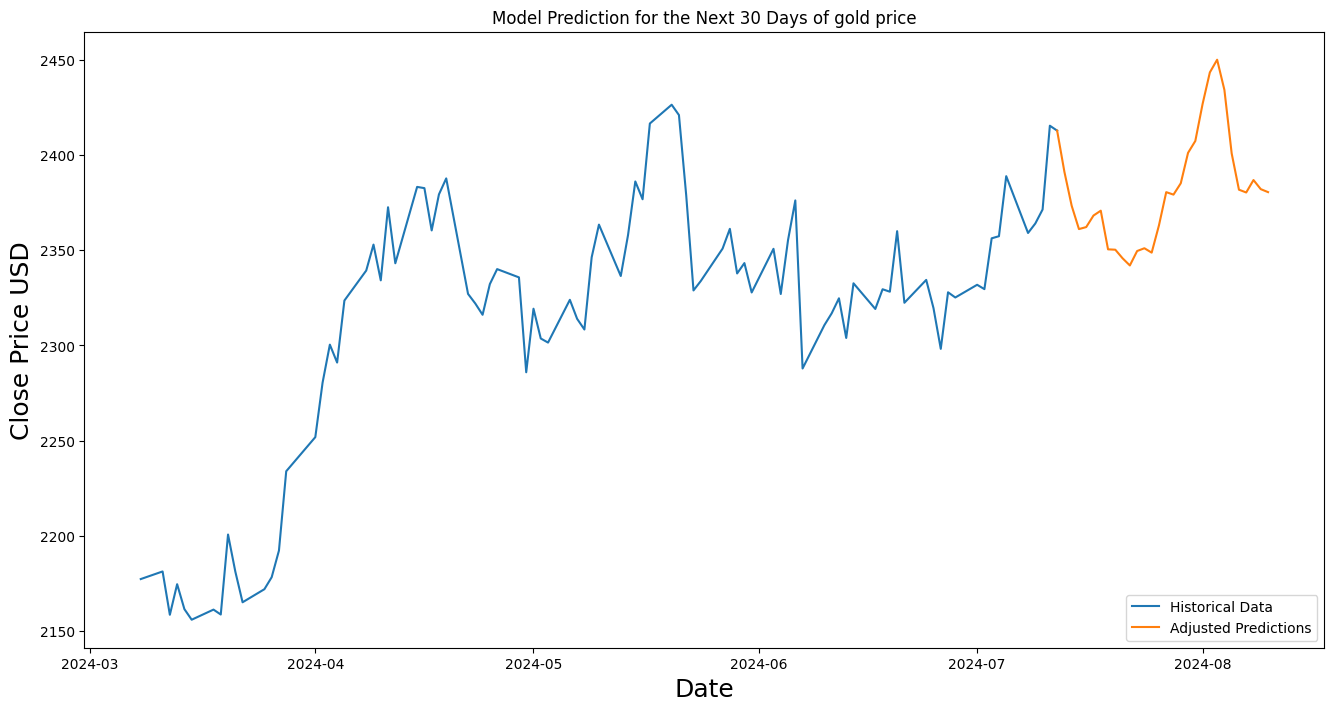

In [95]:
last_historical_non_nan = close_prices_extended[-90:][~np.isnan(close_prices_extended[-90:])][-1]
first_predicted_non_nan = extended_predictions[:30][~np.isnan(extended_predictions[:30])][0]

# Calculate the difference between the last non-NaN value of historical data and the first non-NaN value of predicted data
prediction_difference = last_historical_non_nan - first_predicted_non_nan

# Add the difference to the entire predicted dataset
extended_predictions_adjusted = extended_predictions + prediction_difference

# Plot the data for the last 60 days and the adjusted predicted values
plt.figure( figsize = ( 16, 8 ) )
plt.title( 'Model Prediction for the Next 30 Days of gold price' )
plt.xlabel( 'Date', fontsize = 18 )
plt.ylabel( 'Close Price USD', fontsize = 18 )

plt.plot( df_extended.index[-90:], close_prices_extended[-90:], label = 'Historical Data' )
future_dates = pd.date_range( start = df.index[-1], periods = 30 )
plt.plot( future_dates[:30], extended_predictions_adjusted[:30], label = 'Adjusted Predictions' )

plt.legend( loc = 'lower right' )
plt.show()